In [1]:
import pandas as pd
import pymatgen
import networkx as nx
from pymatgen.core.structure import Structure
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.analysis.local_env import CrystalNN
from moffragmentor import MOF
from pymatgen.io.cif import CifParser
from IPython.display import Image


## PYMATGEN

In [2]:

structure = Structure.from_file("C:/Users/Gabri/Desktop/CIF-TESTE/DB0-m1_o2_bsn_repeat.cif")

# 2. Criar grafo estrutural usando algoritmo de vizinhança
strategy = CrystalNN()  # Algoritmo para encontrar vizinhos
structure_graph = StructureGraph.with_local_env_strategy(structure, strategy)

# 3. Converter para grafo NetworkX
def structure_graph_to_networkx(structure_graph):
    nx_graph = nx.Graph()
    
    # Adicionar nós com atributos atômicos (incluindo o rótulo original do CIF)
    for idx, site in enumerate(structure_graph.structure):
        nx_graph.add_node(idx,
                          label=site.label,  # Rótulo original (e.g., "O1", "O2", etc.)
                          specie=str(site.specie),
                          atomic_number=site.specie.Z,
                          coords=site.coords)
    
    # Adicionar arestas com atributos de ligação
    for (u, v, data) in structure_graph.graph.edges(data=True):
        bond_length = structure.get_distance(u, v, jimage=data["to_jimage"])
        nx_graph.add_edge(u, v, bond_length=bond_length)
    
    return nx_graph

nx_graph = structure_graph_to_networkx(structure_graph)

# 4. Exemplo de uso para ML
print("Número de nós:", nx_graph.number_of_nodes())
print("Número de arestas:", nx_graph.number_of_edges())
print("Atributos do primeiro nó:", nx_graph.nodes[0])
print("Atributos da primeira aresta:", list(nx_graph.edges(data=True))[0])

C:\Users\Gabri\AppData\Local\Temp\ipykernel_14848\594613729.py:5: FutureWarning: with_local_env_strategy is deprecated, and will be removed on 2025-03-20
Use from_local_env_strategy in pymatgen.analysis.graphs instead.
Deprecated on 2024-03-29.
  structure_graph = StructureGraph.with_local_env_strategy(structure, strategy)
D:\Anaconda3\Lib\site-packages\pymatgen\analysis\local_env.py:4019: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  r1 = _get_radius(structure[n])
D:\Anaconda3\Lib\site-packages\pymatgen\analysis\local_env.py:4021: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  r2 = _get_radius(entry["site"])
D:\Anaconda3\Lib\site-packages\pymatgen\analysis\local_env.py:3933: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  nn_data = self.get_nn_

Número de nós: 166
Número de arestas: 192
Atributos do primeiro nó: {'label': 'Zn1', 'specie': 'Zn', 'atomic_number': 30, 'coords': array([ 5.33391789,  9.81550614, 10.13235953])}
Atributos da primeira aresta: (0, 140, {'bond_length': 1.8775945898143236})


In [3]:
print("Número de átomos na estrutura:", len(structure))

Número de átomos na estrutura: 166


In [4]:
# Exemplo: Coordenadas do primeiro átomo no CIF vs. grafo
print("Coordenadas do átomo 0 no CIF:", structure[0].coords)
print("Coordenadas do nó 0 no grafo:", nx_graph.nodes[0]["coords"])

Coordenadas do átomo 0 no CIF: [ 5.33391789  9.81550614 10.13235953]
Coordenadas do nó 0 no grafo: [ 5.33391789  9.81550614 10.13235953]


In [5]:
zn_nodes = [n for n in nx_graph.nodes if nx_graph.nodes[n]["specie"] == "Zn"]
for zn in zn_nodes[:5]:  # Inspecione os primeiros 5 átomos de Zn
    neighbors = list(nx_graph.neighbors(zn))
    print(f"Zn {zn} tem {len(neighbors)} ligações: {neighbors}")

Zn 0 tem 4 ligações: [140, 150, 141, 145]
Zn 1 tem 4 ligações: [140, 142, 144, 151]
Zn 2 tem 4 ligações: [140, 143, 147, 146]
Zn 3 tem 4 ligações: [140, 149, 152, 148]
Zn 4 tem 4 ligações: [153, 154, 163, 158]


In [6]:
# Encontrar nós de Zn pelo símbolo ou rótulo
zn_nodes = [node for node in nx_graph.nodes() 
            if nx_graph.nodes[node]['specie'] == 'Zn' 
            or nx_graph.nodes[node]['label'].startswith('Zn')]

if not zn_nodes:
    print("Nenhum átomo de Zinco (Zn) encontrado.")
else:
    for zn_node in zn_nodes:
        neighbors = list(nx_graph.neighbors(zn_node))
        connections = []
        for neighbor in neighbors:
            bond_data = nx_graph.get_edge_data(zn_node, neighbor)
            bond_length = bond_data['bond_length']
            neighbor_label = nx_graph.nodes[neighbor]['label']  # Rótulo do oxigênio (e.g., "O2")
            neighbor_specie = nx_graph.nodes[neighbor]['specie']
            connections.append(f"{neighbor_label} ({neighbor_specie}, Nó {neighbor}, Distância: {bond_length:.3f} Å)")

        print(f"\nÁtomo de Zn (Nó {zn_node}, Rótulo: {nx_graph.nodes[zn_node]['label']}) conectado a:")
        print(*connections, sep="\n")


Átomo de Zn (Nó 0, Rótulo: Zn1) conectado a:
O1 (O, Nó 140, Distância: 1.878 Å)
O11 (O, Nó 150, Distância: 1.912 Å)
O2 (O, Nó 141, Distância: 1.907 Å)
O6 (O, Nó 145, Distância: 1.920 Å)

Átomo de Zn (Nó 1, Rótulo: Zn2) conectado a:
O1 (O, Nó 140, Distância: 1.869 Å)
O3 (O, Nó 142, Distância: 1.899 Å)
O5 (O, Nó 144, Distância: 1.892 Å)
O12 (O, Nó 151, Distância: 1.930 Å)

Átomo de Zn (Nó 2, Rótulo: Zn3) conectado a:
O1 (O, Nó 140, Distância: 1.882 Å)
O4 (O, Nó 143, Distância: 1.912 Å)
O8 (O, Nó 147, Distância: 1.909 Å)
O7 (O, Nó 146, Distância: 1.934 Å)

Átomo de Zn (Nó 3, Rótulo: Zn4) conectado a:
O1 (O, Nó 140, Distância: 1.865 Å)
O10 (O, Nó 149, Distância: 1.887 Å)
O13 (O, Nó 152, Distância: 1.899 Å)
O9 (O, Nó 148, Distância: 1.921 Å)

Átomo de Zn (Nó 4, Rótulo: Zn5) conectado a:
O14 (O, Nó 153, Distância: 1.885 Å)
O15 (O, Nó 154, Distância: 1.899 Å)
O24 (O, Nó 163, Distância: 1.919 Å)
O19 (O, Nó 158, Distância: 1.922 Å)

Átomo de Zn (Nó 5, Rótulo: Zn6) conectado a:
O14 (O, Nó 153, 

## LIGAÇÕES OBTIDAS NO NXGRAPH  VS VESTA SOFTWARE 

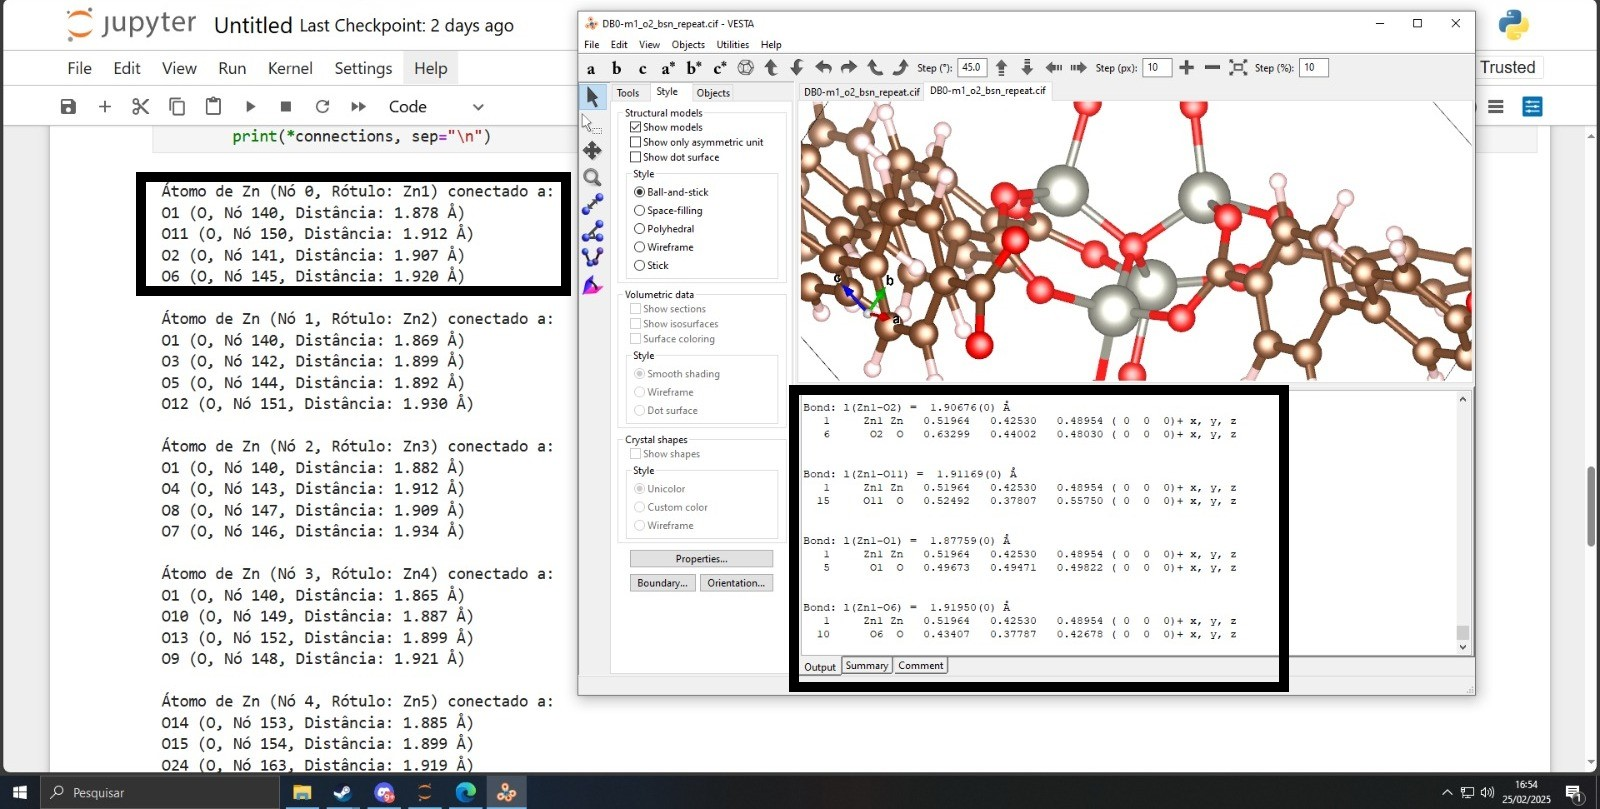

In [7]:
Image(filename='C:/Users/Gabri/Desktop/WhatsApp Image 2025-02-25 at 16.54.15.jpeg')

## MOFFRAGMENTOR

In [8]:
from moffragmentor import MOF
import networkx as nx

# Carregar o MOF e fragmentar
cif_path = "C:/Users/Gabri/Desktop/CIF-TESTE/DB0-m1_o2_bsn_repeat.cif"
mof = MOF.from_cif(cif_path)
fragments = mof.fragment()

D:\Anaconda3\Lib\site-packages\moffragmentor\mof.py:151: FutureWarning: with_local_env_strategy is deprecated, and will be removed on 2025-03-20
Use from_local_env_strategy in pymatgen.analysis.graphs instead.
Deprecated on 2024-03-29.
  structure_graph = StructureGraph.with_local_env_strategy(structure, VestaCutoffDictNN)
D:\Anaconda3\Lib\site-packages\moffragmentor\fragmentor\splitter.py:96: FutureWarning: with_edges is deprecated, and will be removed on 2025-03-20
Use from_edges in pymatgen.analysis.graphs instead.
Deprecated on 2024-03-29.
  graph = MoleculeGraph.with_edges(mol, edge_dict)
D:\Anaconda3\Lib\site-packages\moffragmentor\sbu\node.py:58: FutureWarning: with_edges is deprecated, and will be removed on 2025-03-20
Use from_edges in pymatgen.analysis.graphs instead.
Deprecated on 2024-03-29.
  molecule_graph = MoleculeGraph.with_edges(molecule, edge_dict)


In [9]:
fragments

FragmentationResult(nodes=SBUCollection({'C6 O13 Zn4': 2}), linkers=SBUCollection({'C14 H8 O4': 6}), bound_solvent=NonSbuMoleculeCollection({}), unbound_solvent=NonSbuMoleculeCollection({}), capping_molecules=SBUCollection({}), net_embedding=<moffragmentor.net.Net object at 0x00000290ABE98080>, has_1d_sbu=False)

In [10]:
fragments.nodes

SBUCollection({'C6 O13 Zn4': 2})

## RETIRADA DAS CARGAS PARCIAIS

In [11]:
# RETIRAR AS CARGAS PARCIAIS DO ARQUIVO CIF // É NECESSARIO ACESSAR O "DICT" DO ARQUIVO CIF // O VALOR DA CARGA PODE SER VISTO AO ABRIR O CIF COMO .TXT
# PORÉM : O ARQUIVO DE TESTE NÃO VAI TER CARGA PARCIAL, ENTÃO TALVEZ N FAÇA SENTIDO USAR O ESP COMO VAR.
# A NÃO SER Q DE PRA CALCULAR COM O REPEAT. 


# Agora você pode usar o CifParser
parser = CifParser("C:/Users/Gabri/Desktop/CIF-TESTE/DB0-m1_o2_bsn_repeat.cif")
structures = parser.get_structures()
cif_data = parser.as_dict()


cargas_parciais = cif_data['DB0-m1_o2_bsn']['_atom_type_partial_charge']
tipos_atomicos = cif_data['DB0-m1_o2_bsn']['_atom_site_type_symbol']

dataframe={'tipos_atomicos':tipos_atomicos,'cargas_parciais':cargas_parciais}
df=pd.DataFrame(dataframe)
df

C:\Users\Gabri\AppData\Local\Temp\ipykernel_14848\3939885976.py:8: FutureWarning: get_structures is deprecated; use parse_structures in pymatgen.io.cif instead.
The only difference is that primitive defaults to False in the new parse_structures method.So parse_structures(primitive=True) is equivalent to the old behavior of get_structures().
  structures = parser.get_structures()


,tipos_atomicos,cargas_parciais
0,Zn,1.401704
1,Zn,1.389246
2,Zn,1.399771
3,Zn,1.392581
4,O,-1.661816
...,...,...
161,C,-0.170120
162,H,0.146867
163,C,-0.131002
164,H,0.105049
